In [2]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gmaps

In [3]:
#Read CSV file, convert to dataframe
drg_master = pd.read_csv('data/Inpatient_PYMT_IPPS_DRG_FY2017_CLEAN.csv')
centroids = pd.read_csv('data/state_centroids.csv')
census_master = pd.read_csv('data/state_census_data.csv')
centroids.head(2)

,State,State_Abb,Latitude,Longitude
0,Alabama,AL,32.7794,-86.8287
1,Alaska,AK,64.0685,-152.2782


In [4]:
#Cleanup Column Names
drg_master = drg_master.rename(columns={'DRG Definition': 'DRG', 'Provider Name': 'Name', 'Provider City': 'City',
                                       'Provider State': 'State', 'Provider Zip Code': 'Zip Code',
                                       'Hospital Referral Region (HRR) Description': 'Region', 'Total Discharges': 'Discharges',
                                       'Average Covered Charges': 'List Price', 'Average Total Payments': 'Average Total',
                                       'Average Medicare Payments': 'Average Medicare'})
drg_master.head(2)

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare
0,291 - HEART FAILURE & SHOCK W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,371,34642.05,7771.63,6965.86
1,291 - HEART FAILURE & SHOCK W MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,89,18208.90,8220.40,6905.46


In [5]:
#Data Munging - add Centroid coordinates by state level

drg_master['Latitude']=''
drg_master['Longitude']=''
drg_master['Per Capita Income']= ''
drg_master['Poverty Rate']=''
drg_master['Median Age']=''

for i in range(len(drg_master)):    
        
    for j in range (len(centroids)):
        if str(centroids.iloc[j]['State_Abb']) == str(drg_master.iloc[i]['State']):
            drg_master.ix[i, 'Latitude'] = centroids.iloc[j]['Latitude']
            drg_master.ix[i, 'Longitude'] = centroids.iloc[j]['Longitude']
        if str(census_master.iloc[j]['State']) == str(drg_master.iloc[i]['State']):
            try:
                drg_master.ix[i, 'Per Capita Income'] = census_master.iloc[j]['Per Capita Income']
                drg_master.ix[i, 'Poverty Rate'] = census_master.iloc[j]['Poverty Rate']
                drg_master.ix[i, 'Median Age'] = census_master.iloc[j]['Median Age']
            except (KeyError, IndexError):
                drg_master.ix[i, 'Per Capita Income'] = ''
                drg_master.ix[i, 'Poverty Rate'] = ''
                drg_master.ix[i, 'Median Age'] = ''
drg_master.head()

C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\fireh\Anaconda3\env

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare,Latitude,Longitude,Per Capita Income,Poverty Rate,Median Age
0,291 - HEART FAILURE & SHOCK W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,371,34642.05,7771.63,6965.86,32.7794,-86.8287,23680,18.1409,38.1
1,291 - HEART FAILURE & SHOCK W MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,89,18208.90,8220.40,6905.46,32.7794,-86.8287,23680,18.1409,38.1
2,291 - HEART FAILURE & SHOCK W MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,238,33568.66,7310.01,6292.20,32.7794,-86.8287,23680,18.1409,38.1
3,291 - HEART FAILURE & SHOCK W MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,148,44123.34,8488.86,7244.08,32.7794,-86.8287,23680,18.1409,38.1
4,291 - HEART FAILURE & SHOCK W MCC,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,AL - Birmingham,32,54984.84,8317.91,7620.53,32.7794,-86.8287,23680,18.1409,38.1


In [6]:
drg_master.to_csv('drg_updated.csv',encoding='utf-8')

In [7]:
#Hive off Diabetes and Joint Replacement procedures to new dataframes
diabetes_master = drg_master.loc[drg_master['DRG'] == '638 - DIABETES W CC']
joint_master = drg_master.loc[drg_master['DRG'] == '470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC']

#Create average and st_dev dataframes, sorted by descending
diabetes_stdev = diabetes_master.groupby('State').std().drop(['Provider Id', 'Zip Code', 'Discharges'],axis=1)
diabetes_avgtotal = diabetes_master.groupby('State').mean().dropna()

joint_avgtotal = joint_master.groupby('State').mean().dropna()
joint_stdev = joint_master.groupby('State').std().drop(['Provider Id', 'Zip Code', 'Discharges'],axis=1)

#Print Joint Std_Dev sorted by List Price (covered charges)
#joint_stdev.sort_values(by=['Average Total'], ascending=False)


In [90]:
#Print Diabetes Std_Dev sorted by List Price (covered charges)
diabetes_stdev.sort_values(by=['List Price'], ascending=False)

,State,List Price,Average Total,Average Medicare,Per Capita Income,Latitude,Longitude
31,NJ,20505.761289,1576.911330,1175.678073,0.0,40.1907,-74.6728
4,CA,18309.857682,2520.417512,2369.803427,0.0,37.1841,-119.4696
38,PA,16235.911976,1842.524003,1152.329736,0.0,40.8781,-77.7996
25,MS,15839.056195,890.558820,768.308840,0.0,32.7364,-89.6678
1,AL,15274.962317,693.668359,465.921945,0.0,32.7794,-86.8287
34,NY,15009.995636,3086.944511,2724.370676,0.0,42.9538,-75.5268
33,NV,14676.158146,1546.988530,1322.550379,0.0,39.3289,-116.6312
9,FL,14111.461349,1598.145099,1162.311862,0.0,28.6305,-82.4497
43,TX,13091.000988,1773.754223,1417.593893,0.0,31.4757,-99.3312
5,CO,12669.832285,1135.585962,421.123195,0.0,38.9972,-105.5478


In [9]:
#More Data Munging - add Centroid coordinates by state level, re-add to St_Dev and Average group-by dataframes

joint_stdev.reset_index(level=0, inplace=True)
joint_avgtotal.reset_index(level=0, inplace=True)
diabetes_stdev.reset_index(level=0, inplace=True)
diabetes_avgtotal.reset_index(level=0, inplace=True)
joint_stdev['Latitude']=''
joint_avgtotal['Longitude']=''
diabetes_stdev['Latitude']=''
diabetes_avgtotal['Longitude']=''

for i in range(len(centroids)):    
        
    for j in range (len(centroids)):
        if str(centroids.iloc[j]['State_Abb']) == str(joint_stdev.iloc[i]['State']):
            joint_stdev.ix[i, 'Latitude'] = centroids.iloc[j]['Latitude']
            joint_stdev.ix[i, 'Longitude'] = centroids.iloc[j]['Longitude']
        if str(centroids.iloc[j]['State_Abb']) == str(joint_avgtotal.iloc[i]['State']):
            joint_avgtotal.ix[i, 'Latitude'] = centroids.iloc[j]['Latitude']
            joint_avgtotal.ix[i, 'Longitude'] = centroids.iloc[j]['Longitude']
        if str(centroids.iloc[j]['State_Abb']) == str(diabetes_stdev.iloc[i]['State']):
            diabetes_stdev.ix[i, 'Latitude'] = float(centroids.iloc[j]['Latitude'])
            diabetes_stdev.ix[i, 'Longitude'] = float(centroids.iloc[j]['Longitude'])
        if str(centroids.iloc[j]['State_Abb']) == str(diabetes_avgtotal.iloc[i]['State']):
            diabetes_avgtotal.ix[i, 'Latitude'] = float(centroids.iloc[j]['Latitude'])
            diabetes_avgtotal.ix[i, 'Longitude'] = float(centroids.iloc[j]['Longitude'])

C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\fireh\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\fireh\Anacon

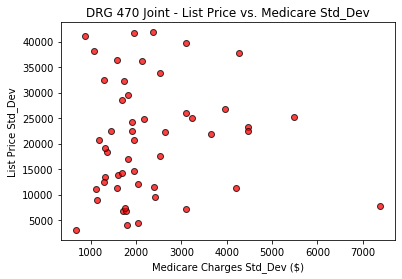

In [12]:
# Joints - Create Matplotlib scatter based on Std_Dev List Price vs. Avg Medicare
plt.title("DRG 470 Joint - List Price vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('List Price Std_Dev')
plt.scatter(joint_stdev['Average Medicare'],joint_stdev['List Price'], marker="o", facecolors="red", edgecolors="black",alpha=0.75)
plt.savefig('data/drg470joint_list_medicare.png')

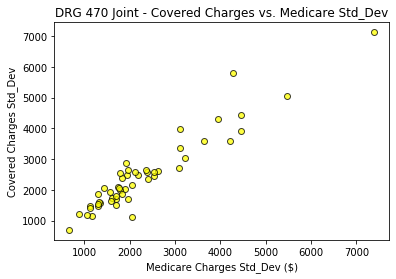

In [13]:
# Joints - Create Matplotlib scatter based on Std_Dev Avg Total vs. Avg Medicare
plt.title("DRG 470 Joint - Covered Charges vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('Covered Charges Std_Dev')
plt.scatter(joint_stdev['Average Medicare'],joint_stdev['Average Total'], marker="o", facecolors="yellow", edgecolors="black",alpha=0.75)
plt.savefig('data/drg470joint_covered_medicare.png')

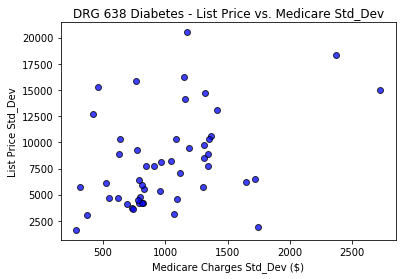

In [14]:
# Diabetes - Create Matplotlib scatter based on Std_Dev List Price vs. Avg Medicare
plt.title("DRG 638 Diabetes - List Price vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('List Price Std_Dev')
plt.scatter(diabetes_stdev['Average Medicare'],diabetes_stdev['List Price'], marker="o", facecolors="blue", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_list_medicare.png')

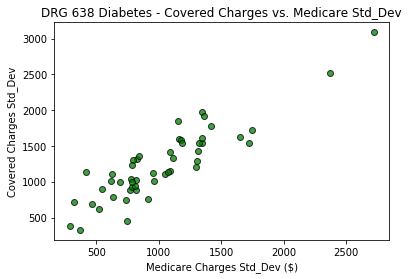

In [15]:
# Diabetes - Create Matplotlib scatter based on Std_Dev Avg Total vs. Avg Medicare
plt.title("DRG 638 Diabetes - Covered Charges vs. Medicare Std_Dev")
plt.xlabel('Medicare Charges Std_Dev ($)')
plt.ylabel('Covered Charges Std_Dev')
plt.scatter(diabetes_stdev['Average Medicare'],diabetes_stdev['Average Total'], marker="o", facecolors="green", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_covered_medicare.png')

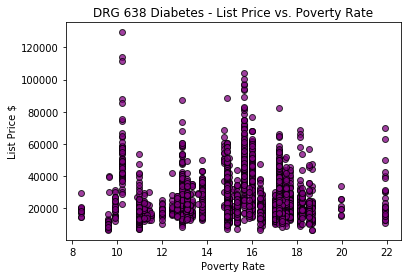

In [20]:
# Diabetes vs. Poverty Rate - Create Matplotlib scatter based on List Price vs. Poverty Rate
plt.title("DRG 638 Diabetes - List Price vs. Poverty Rate")
plt.xlabel('Poverty Rate')
plt.ylabel('List Price $')
plt.scatter(diabetes_master['Poverty Rate'],diabetes_master['List Price'], marker="o", facecolors="purple", edgecolors="black",alpha=0.75)
plt.savefig('data/drg638diabetes_list_poverty.png')

In [154]:
#Examine Mississippi, Diabetes
diabetes_state_list = []
diabetes_state_medicare = []
diabetes_zipcode = []

for i in range (len(diabetes_master)):
    if diabetes_master.iloc[i]['State'] == 'MS':
        diabetes_state_list.append(diabetes_master.iloc[i]['List Price'])
        diabetes_state_medicare.append(diabetes_master.iloc[i]['Average Medicare'])
        diabetes_zipcode.append(diabetes_master.iloc[i]['City'])
diabetes_state_list.sort(reverse=True)
diabetes_state_medicare.sort(reverse=True)

No handles with labels found to put in legend.


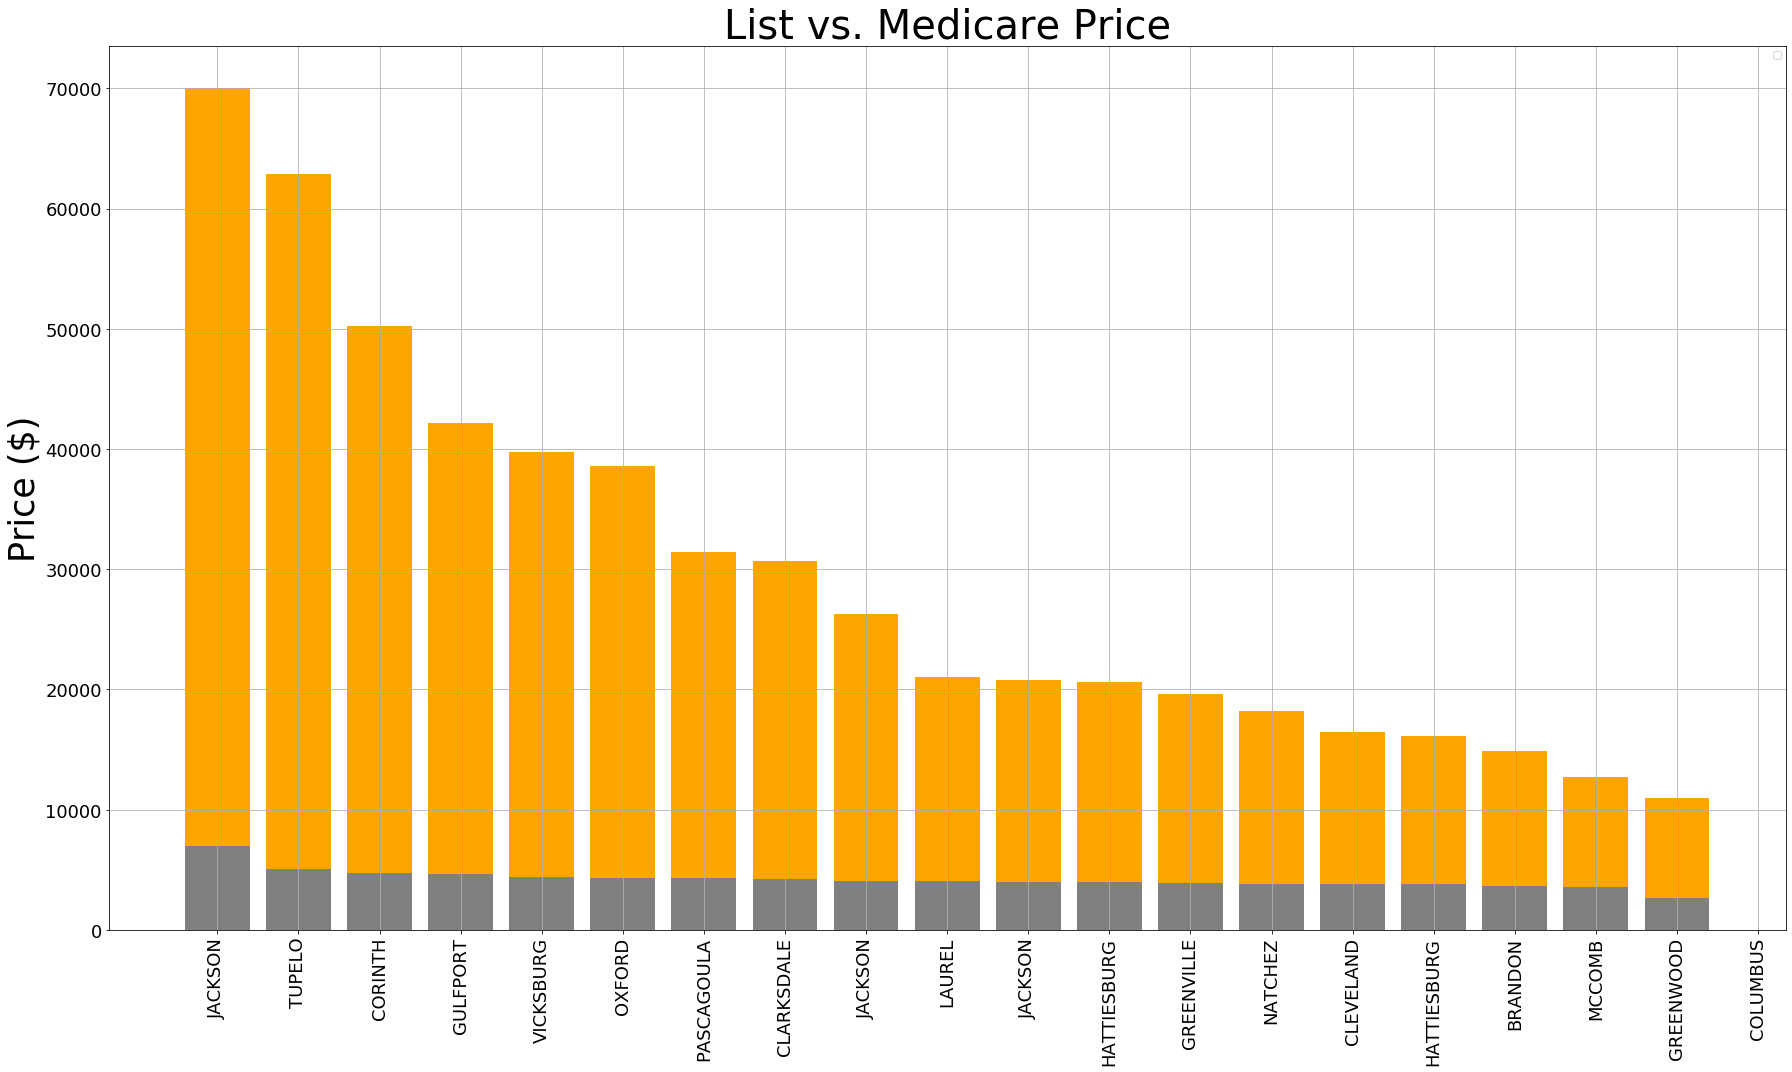

In [82]:
# Orient widths. Add labels, tick marks, etc. 
fig, ax = plt.subplots(figsize=(25,15))
x_range = np.arange(0,len(diabetes_state_list))
font = 18

tick_locations = [value for value in x_range]
plt.xticks (tick_locations, diabetes_zipcode, rotation=90, size = font)
plt.yticks (size = font)

#Plot Bar Charts
ax.bar(diabetes_zipcode, diabetes_state_list, color='orange', alpha=1, align="center")
ax.bar(diabetes_zipcode, diabetes_state_medicare, color='gray', alpha=1, align="center")

#Set Titles
plt.title("List vs. Medicare Price",size = 40)
plt.ylabel("Price ($)",size = 35)
plt.grid(True)
fig.tight_layout()
plt.legend()

In [36]:
#Examine Mississippi, Joint
joint_state_list = []
joint_state_medicare = []
joint_zipcode = []

for i in range (len(joint_master)):
    if joint_master.iloc[i]['State'] == 'MS':
        joint_state_list.append(joint_master.iloc[i]['List Price'])
        joint_state_medicare.append(joint_master.iloc[i]['Average Medicare'])
        joint_zipcode.append(joint_master.iloc[i]['City'])
        
joint_state_list.sort(reverse=True)
joint_state_medicare.sort(reverse=True)

[14040.15, 11481.36, 11388.24, 11086.01, 10775.62, 10774.81, 10738.95, 10685.65, 10639.29, 10453.67, 10446.82, 10402.29, 10375.59, 10267.93, 10222.24, 10176.91, 10136.03, 10117.3, 9943.35, 9931.55, 9786.63, 9591.0, 9535.74, 9333.02, 9320.62, 9258.85, 9227.87, 8972.17, 8842.41, 8759.58, 8720.96, 8311.05]


No handles with labels found to put in legend.


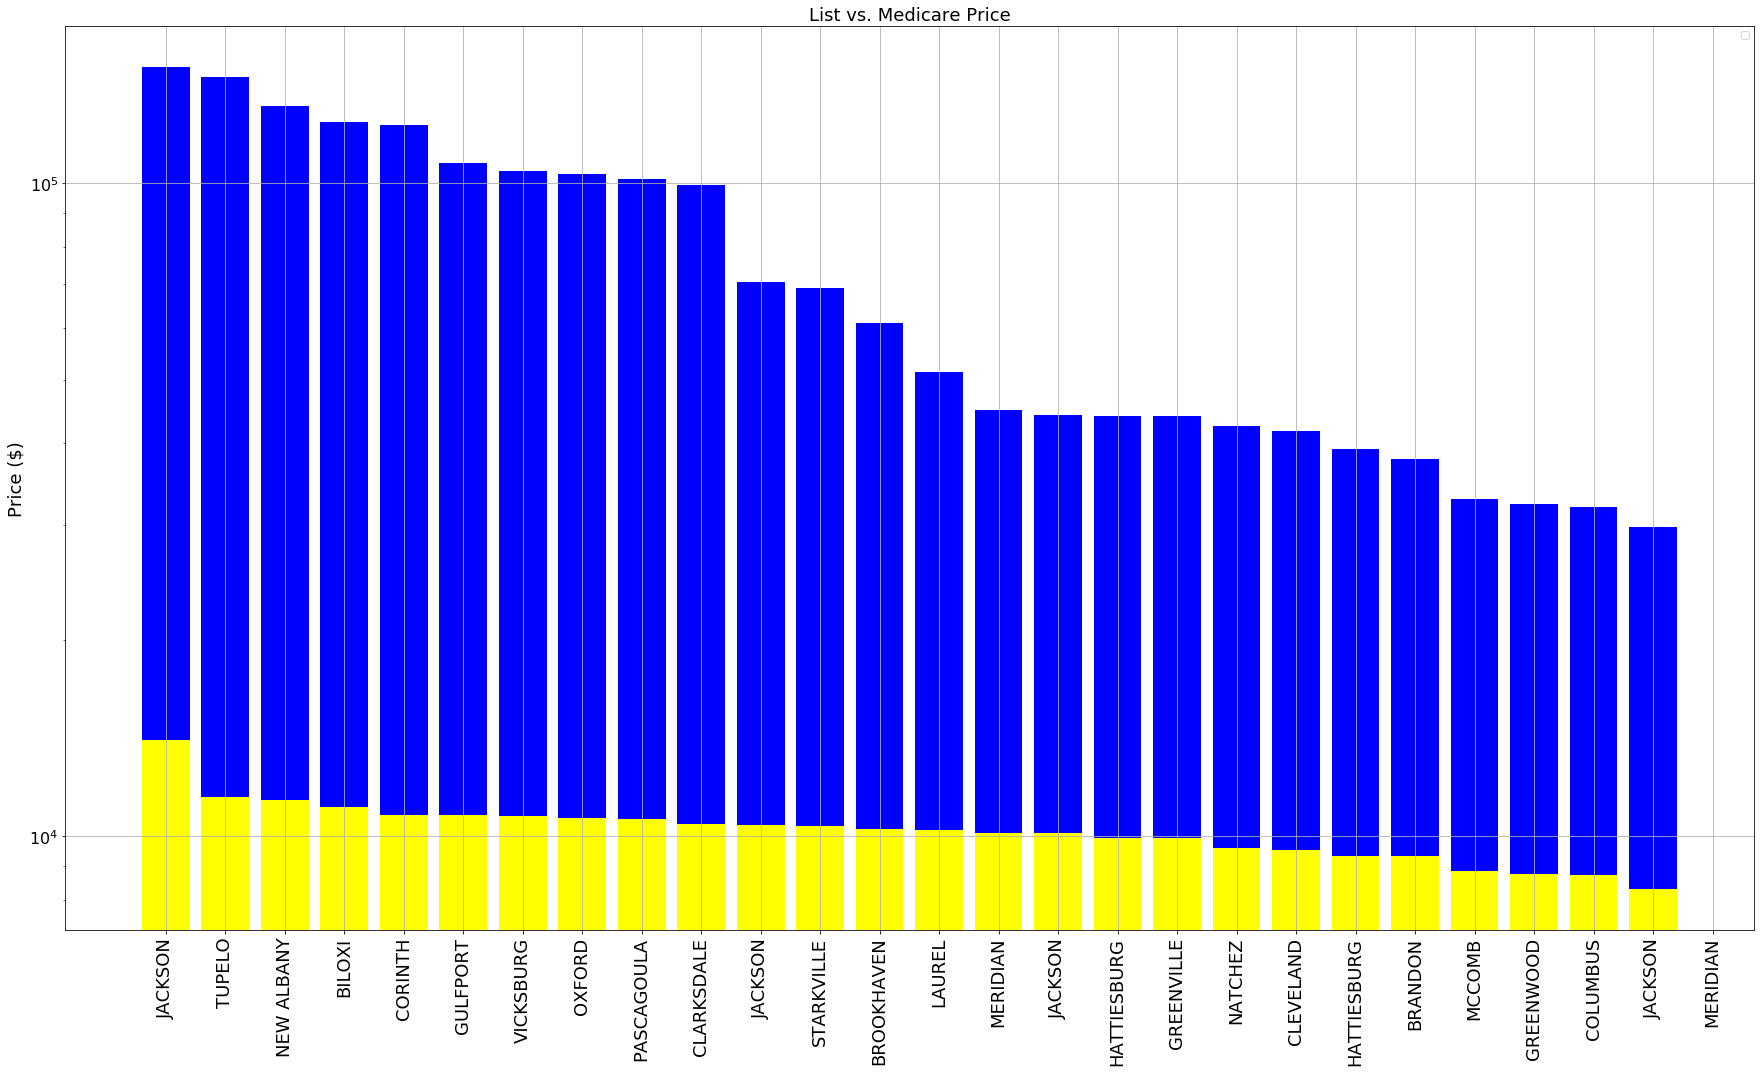

In [37]:
# Orient widths. Add labels, tick marks, etc. 
fig, ax = plt.subplots(figsize=(25,15))
x_range = np.arange(0,len(joint_state_list))
font = 18

tick_locations = [value for value in x_range]
plt.xticks (tick_locations, joint_zipcode, size = font, rotation=90)
plt.yticks (size = '16')

#Plot Bar Charts
ax.bar(joint_zipcode, joint_state_list, color='Blue', alpha=1, align="center")
ax.bar(joint_zipcode, joint_state_medicare, color='yellow', alpha=1, align="center")

#Set Titles
plt.title("List vs. Medicare Price", size = font)
plt.ylabel("Price ($)", size = font)
plt.grid(True)
plt.legend()
fig.tight_layout()
ax.set_yscale('log')

In [73]:
#GMAPS PREP - Convert st_dev dataframe Lat, Long columns to float, supporting Heatmaps 

#diabetes
diabetes_stdev.dropna(inplace=True)

m = pd.to_numeric(diabetes_stdev['Latitude'])
diabetes_stdev['Latitude'] = m

n = pd.to_numeric(diabetes_stdev['Longitude'])
diabetes_stdev['Longitude'] = n
diabetes_stdev['Latitude']

#joint
joint_stdev.dropna(inplace=True)

m = pd.to_numeric(joint_stdev['Latitude'])
joint_stdev['Latitude'] = m

n = pd.to_numeric(joint_stdev['Longitude'])
joint_stdev['Longitude'] = n

In [115]:
#gmaps.Map()

#Set Locations, Weights - can modify weights with new column
locations = diabetes_stdev[['Latitude', 'Longitude']]
weights = diabetes_stdev['List Price']

m = gmaps.figure()
m.add_layer(gmaps.heatmap_layer(locations, weights=weights, point_radius=20.0))
m

Figure(layout=FigureLayout(height='420px'))

In [94]:
#Drill into Mississippi - DIABETES
diabetes_ms = diabetes_master.loc[diabetes_master['State'] == 'MS']
diabetes_ms.sort_values(by='List Price', ascending=False)
#### OBSERVED - JACKSON, AND HATTIESBURG LARGE / SMALL REGIONS ARE OF INTEREST

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare,Latitude,Longitude,Per Capita Income,Poverty Rate,Median Age
8892,638 - DIABETES W CC,250072,MERIT HEALTH CENTRAL,1850 CHADWICK DR,JACKSON,MS,39204,MS - Jackson,11,69990.18,5607.00,4777.18,32.7364,-89.6678,20618,21.9466,36.2
8885,638 - DIABETES W CC,250019,MEMORIAL HOSPITAL AT GULFPORT,4500 13TH STREET,GULFPORT,MS,39502,MS - Gulfport,42,62883.50,5258.81,3864.95,32.7364,-89.6678,20618,21.9466,36.2
8898,638 - DIABETES W CC,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,MS,39042,MS - Jackson,13,50234.38,4644.38,3560.46,32.7364,-89.6678,20618,21.9466,36.2
8889,638 - DIABETES W CC,250042,NORTHWEST MISSISSIPPI MEDICAL CENTER,1970 HOSPITAL DRIVE,CLARKSDALE,MS,38614,TN - Memphis,14,42190.21,5909.29,5071.29,32.7364,-89.6678,20618,21.9466,36.2
8886,638 - DIABETES W CC,250031,MERIT HEALTH RIVER REGION,2100 HWY 61 N,VICKSBURG,MS,39183,MS - Jackson,16,39734.69,5475.50,4409.75,32.7364,-89.6678,20618,21.9466,36.2
8897,638 - DIABETES W CC,250094,MERIT HEALTH WESLEY,5001 W HARDY ST,HATTIESBURG,MS,39402,MS - Hattiesburg,27,38610.89,5225.48,4030.89,32.7364,-89.6678,20618,21.9466,36.2
8904,638 - DIABETES W CC,250123,GARDEN PARK MEDICAL CENTER,15200 COMMUNITY ROAD,GULFPORT,MS,39503,MS - Gulfport,13,31398.46,4902.54,2636.46,32.7364,-89.6678,20618,21.9466,36.2
8895,638 - DIABETES W CC,250084,MERIT HEALTH NATCHEZ,52 SERGEANT PRENTISS DRIVE,NATCHEZ,MS,39120,MS - Jackson,15,30704.13,5425.93,4291.00,32.7364,-89.6678,20618,21.9466,36.2
8888,638 - DIABETES W CC,250040,SINGING RIVER HOSPITAL,2809 DENNY AV,PASCAGOULA,MS,39581,AL - Mobile,34,30073.62,4940.18,3573.56,32.7364,-89.6678,20618,21.9466,36.2
8884,638 - DIABETES W CC,250009,MAGNOLIA REGIONAL HEALTH CENTER,611 ALCORN DRIVE,CORINTH,MS,38834,TN - Memphis,36,26304.33,5852.42,4066.03,32.7364,-89.6678,20618,21.9466,36.2


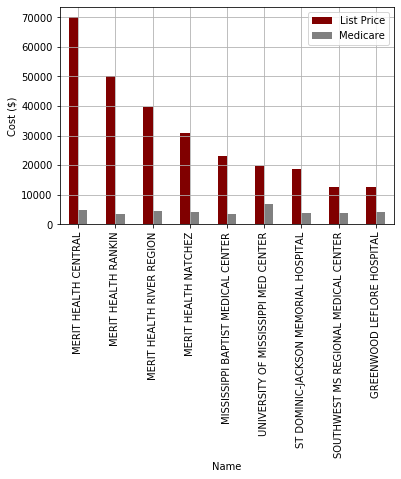

In [152]:
#Drill into Jackson, Mississippi Region - DIABETES
diabetes_jackson = diabetes_ms.loc[diabetes_ms['Region'] == 'MS - Jackson']

#Trim dataframe, plot bar graph
diabetes_j = pd.DataFrame({'List Price': (diabetes_jackson['List Price'].values),
                        'Medicare':(diabetes_jackson['Average Medicare'].values)},
                       index=diabetes_jackson['Name']).sort_values(by='List Price', ascending=False)
my_colors=('maroon', 'gray')
ax = diabetes_j.plot.bar(color = my_colors, rot=90)
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()

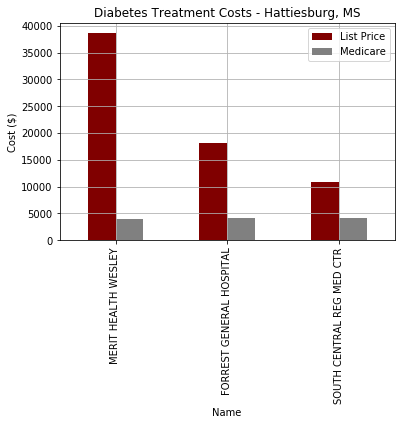

In [151]:
#Drill into Hattiesburg, Mississippi Region - DIABETES
diabetes_hattiesburg = diabetes_ms.loc[diabetes_ms['Region'] == 'MS - Hattiesburg']

#Trim dataframe, plot bar graph
diabetes_h = pd.DataFrame({'List Price': (diabetes_hattiesburg['List Price'].values),
                        'Medicare':(diabetes_hattiesburg['Average Medicare'].values)},
                       index=diabetes_hattiesburg['Name']).sort_values(by='List Price', ascending=False)
my_colors=('maroon', 'gray')
ax = diabetes_h.plot.bar(color = my_colors, rot=90)
plt.title("Diabetes Treatment Costs - Hattiesburg, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()

In [97]:
#Drill into Mississippi - JOINTS
joint_ms = joint_master.loc[joihatnt_master['State'] == 'MS']
joint_ms.sort_values(by='List Price', ascending=False)
#### OBSERVED - JACKSON, AND HATTIESBURG LARGE / SMALL REGIONS ARE OF INTEREST

,DRG,Provider Id,Name,Provider Street Address,City,State,Zip Code,Region,Discharges,List Price,Average Total,Average Medicare,Latitude,Longitude,Per Capita Income,Poverty Rate,Median Age
6634,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250007,MERIT HEALTH BILOXI,150 REYNOIR STREET,BILOXI,MS,39530,MS - Gulfport,51,150442.92,15437.92,9333.02,32.7364,-89.6678,20618,21.9466,36.2
6646,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250072,MERIT HEALTH CENTRAL,1850 CHADWICK DR,JACKSON,MS,39204,MS - Jackson,40,145655.78,12405.62,10775.62,32.7364,-89.6678,20618,21.9466,36.2
6652,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250096,MERIT HEALTH RANKIN,350 CROSSGATES BLVD,BRANDON,MS,39042,MS - Jackson,16,131377.62,11430.38,9320.62,32.7364,-89.6678,20618,21.9466,36.2
6640,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250042,NORTHWEST MISSISSIPPI MEDICAL CENTER,1970 HOSPITAL DRIVE,CLARKSDALE,MS,38614,TN - Memphis,14,124303.07,12791.36,11481.36,32.7364,-89.6678,20618,21.9466,36.2
6659,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250138,MERIT HEALTH RIVER OAKS,1030 RIVER OAKS DRIVE,FLOWOOD,MS,39232,MS - Jackson,212,122952.75,13442.76,10176.91,32.7364,-89.6678,20618,21.9466,36.2
6636,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250019,MEMORIAL HOSPITAL AT GULFPORT,4500 13TH STREET,GULFPORT,MS,39502,MS - Gulfport,231,107512.24,11987.70,8972.17,32.7364,-89.6678,20618,21.9466,36.2
6658,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250123,GARDEN PARK MEDICAL CENTER,15200 COMMUNITY ROAD,GULFPORT,MS,39503,MS - Gulfport,112,104291.79,11661.48,8311.05,32.7364,-89.6678,20618,21.9466,36.2
6650,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250093,BOLIVAR MEDICAL CENTER,901 E SUNFLOWER RD,CLEVELAND,MS,38732,TN - Memphis,21,103158.76,12265.52,10738.95,32.7364,-89.6678,20618,21.9466,36.2
6637,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250031,MERIT HEALTH RIVER REGION,2100 HWY 61 N,VICKSBURG,MS,39183,MS - Jackson,37,101680.00,12049.16,10375.59,32.7364,-89.6678,20618,21.9466,36.2
6649,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,250084,MERIT HEALTH NATCHEZ,52 SERGEANT PRENTISS DRIVE,NATCHEZ,MS,39120,MS - Jackson,26,99335.04,12609.19,10774.81,32.7364,-89.6678,20618,21.9466,36.2


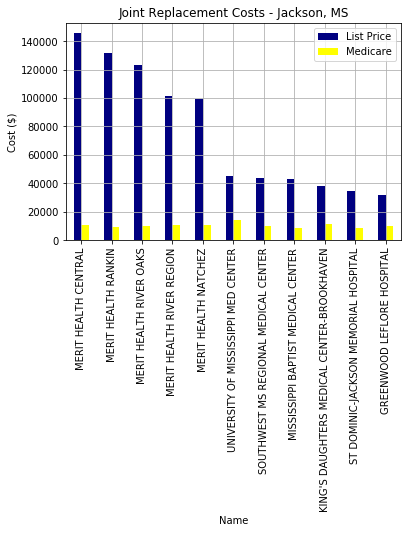

In [150]:
#Drill into Jackson, Mississippi Region - JOINT
joint_jackson = joint_ms.loc[joint_ms['Region'] == 'MS - Jackson']
joint_jackson.sort_values(by='List Price', ascending=False)

#Trim dataframe, plot bar graph
joint_j = pd.DataFrame({'List Price': (joint_jackson['List Price'].values),
                        'Medicare':(joint_jackson['Average Medicare'].values)},
                       index=joint_jackson['Name']).sort_values(by='List Price', ascending=False)
my_colors=('navy', 'yellow')
ax = joint_j.plot.bar(color = my_colors, rot=90)
plt.title("Joint Replacement Costs - Jackson, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()

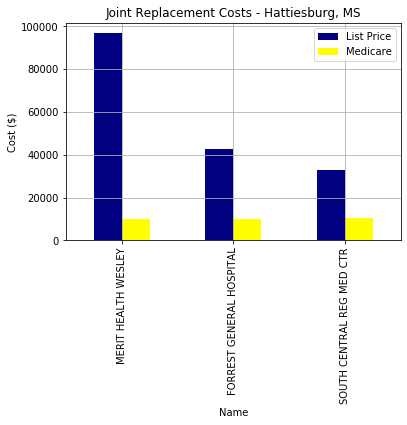

In [148]:
#Drill into Gulfport, Mississippi Region - JOINT
joint_hattiesburg = joint_ms.loc[joint_ms['Region'] == 'MS - Hattiesburg']
joint_hattiesburg.sort_values(by='List Price', ascending=False)

#Trim dataframe, plot bar graph
joint_h = pd.DataFrame({'List Price': (joint_hattiesburg['List Price'].values),
                        'Medicare':(joint_hattiesburg['Average Medicare'].values)},
                       index=joint_hattiesburg['Name']).sort_values(by='List Price', ascending=False)
my_colors=('navy', 'yellow')
ax = joint_h.plot.bar(color = my_colors, rot=90)
plt.title("Joint Replacement Costs - Hattiesburg, MS")
plt.ylabel("Cost ($)")
plt.grid(True)
fig.tight_layout()